#  Uneven planner

In [2]:
import matplotlib.pyplot as plt

In [3]:
import os
from os import path as osp
import numpy as np
import pickle

from utils import geom2pix

from skimage import io

import sys
sys.modules['numpy._core'] = np
sys.modules['numpy._core._multiarray_umath'] = np.core._multiarray_umath
sys.modules['numpy._core.multiarray'] = np.core.multiarray

In [4]:
import torch
import torch.nn.functional as F
import json

from transformer import Models
from dataLoader_uneven import get_encoder_input, receptive_field
from eval_model_uneven import getHashTable, get_patch

## Point Robot 

### Load Trained Model

Pick either the Point or Dubins Car model to load.

In [10]:
# Define the network
device='cuda' if torch.cuda.is_available() else 'cpu'

modelFolder = 'data/uneven'
epoch = 39

modelFile = osp.join(modelFolder, f'model_params.json')
model_param = json.load(open(modelFile))

transformer = Models.UnevenTransformer(**model_param)
_ = transformer.to(device)

In [11]:
# checkpoint = torch.load(osp.join(modelFolder, f'model_epoch_{epoch}.pkl'))
stage = 2
checkpoint = torch.load(osp.join(modelFolder, f'stage{stage}_model_epoch_{epoch}.pkl'))
transformer.load_state_dict(checkpoint['state_dict'])

_ = transformer.eval()

###  Load the Map

Choose an environment to plan paths for. For the  point robot, you can choose between forest or maze.

(-0.5, 1303.5, 952.5, -0.5)

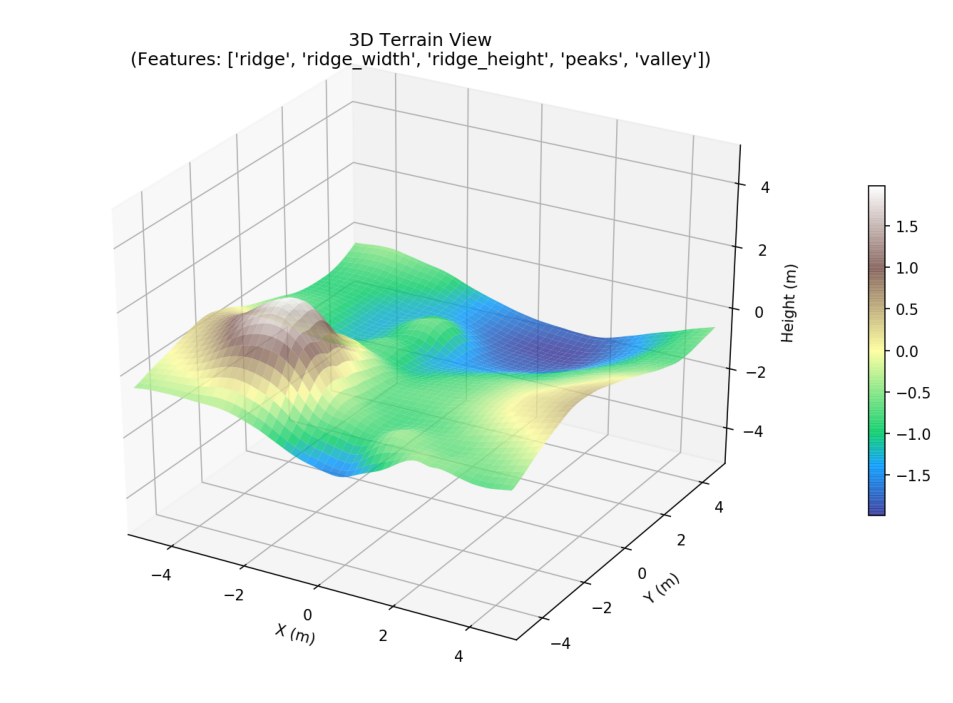

In [25]:
# Plot the patches
# envType = 'desert'
envType = 'env000000'
envFolder = osp.join('data/terrain_dataset/val', envType)
    
fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# plt.subplots_adjust(wspace=0.3)  # 增加子图间的水平间距

image_path = osp.join(envFolder, f'terrain_3d.png')
image = plt.imread(image_path)
ax.imshow(image)
ax.axis('off')  # 关闭坐标轴

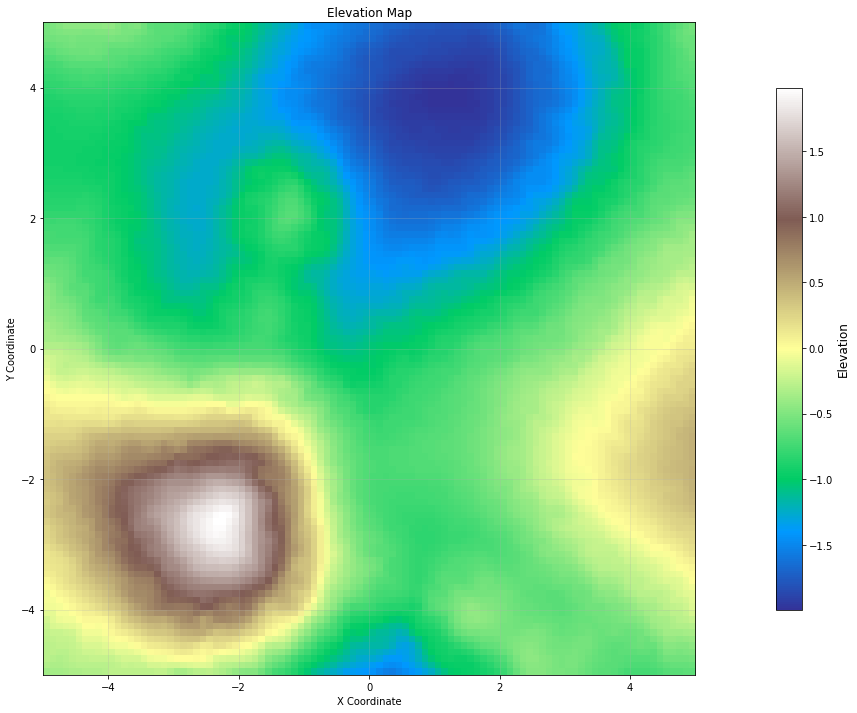

In [26]:
env_path = osp.join(envFolder, f'map.p')
with open(env_path, 'rb') as f:
    env = pickle.load(f)
    tensor = env['tensor']
    elevation = tensor[:, :, 0]
    normal_x = tensor[:, :, 1]
    normal_y = tensor[:, :, 2]
    normal_z = tensor[:, :, 3]
    
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
fig, ax = plt.subplots(1, 1, figsize=(36, 12))
elevation_masked = np.ma.masked_invalid(elevation)
im = ax.imshow(elevation_masked, extent=[-5, 5, -5, 5],
                origin='lower', cmap='terrain', aspect='equal')
cbar = plt.colorbar(im, ax=ax, shrink=0.8, fraction=0.046, pad=0.04)
cbar.set_label('Elevation', fontsize=12)
ax.set_title('Elevation Map')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.grid(True, alpha=0.3)

## Define the Start and Goal Point

Define your own start and goal point or choose a path from the validation data

(-5.0, 5.0, -5.0, 5.0)

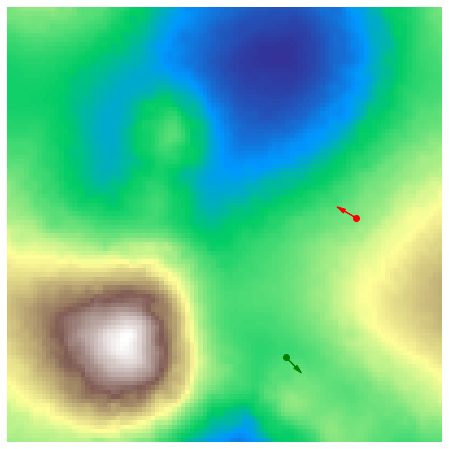

In [28]:
# Plot the path
pathNum = 4
path_file = osp.join(envFolder, f'path_{pathNum}.p')
with open(path_file, 'rb') as f:
    path_data = pickle.load(f)
    trajectory = path_data['path']  # [N, 3]
    
start_pos = trajectory[0, :]
goal_pos = trajectory[-1, :]

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
elevation_masked = np.ma.masked_invalid(elevation)
im = ax.imshow(elevation_masked, extent=[-5, 5, -5, 5],
                origin='lower', cmap='terrain', aspect='equal')
ax.grid(True, alpha=0.3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
# 绘制朝向
arrow_scale = 0.3
ax.arrow(start_pos[0], start_pos[1],
            np.cos(start_pos[2]) * arrow_scale,
            np.sin(start_pos[2]) * arrow_scale,
            head_width=0.1, head_length=0.2, fc='g', ec='g', zorder=3)
ax.arrow(goal_pos[0], goal_pos[1],
            np.cos(goal_pos[2]) * arrow_scale,
            np.sin(goal_pos[2]) * arrow_scale,
            head_width=0.1, head_length=0.2, fc='r', ec='r', zorder=3)
ax.axis('off')  # 关闭坐标轴

### Generate the Patch

In [30]:
patch_map, predProb, predTraj = get_patch(transformer, start_pos, goal_pos, normal_x, normal_y, normal_z)

Input map shape: (100, 100)
Encoder input shape: (100, 100, 6)
Encoder input tensor shape: torch.Size([6, 100, 100])


patch_map shape: (10, 100, 100)
predProb shape: torch.Size([10, 144])


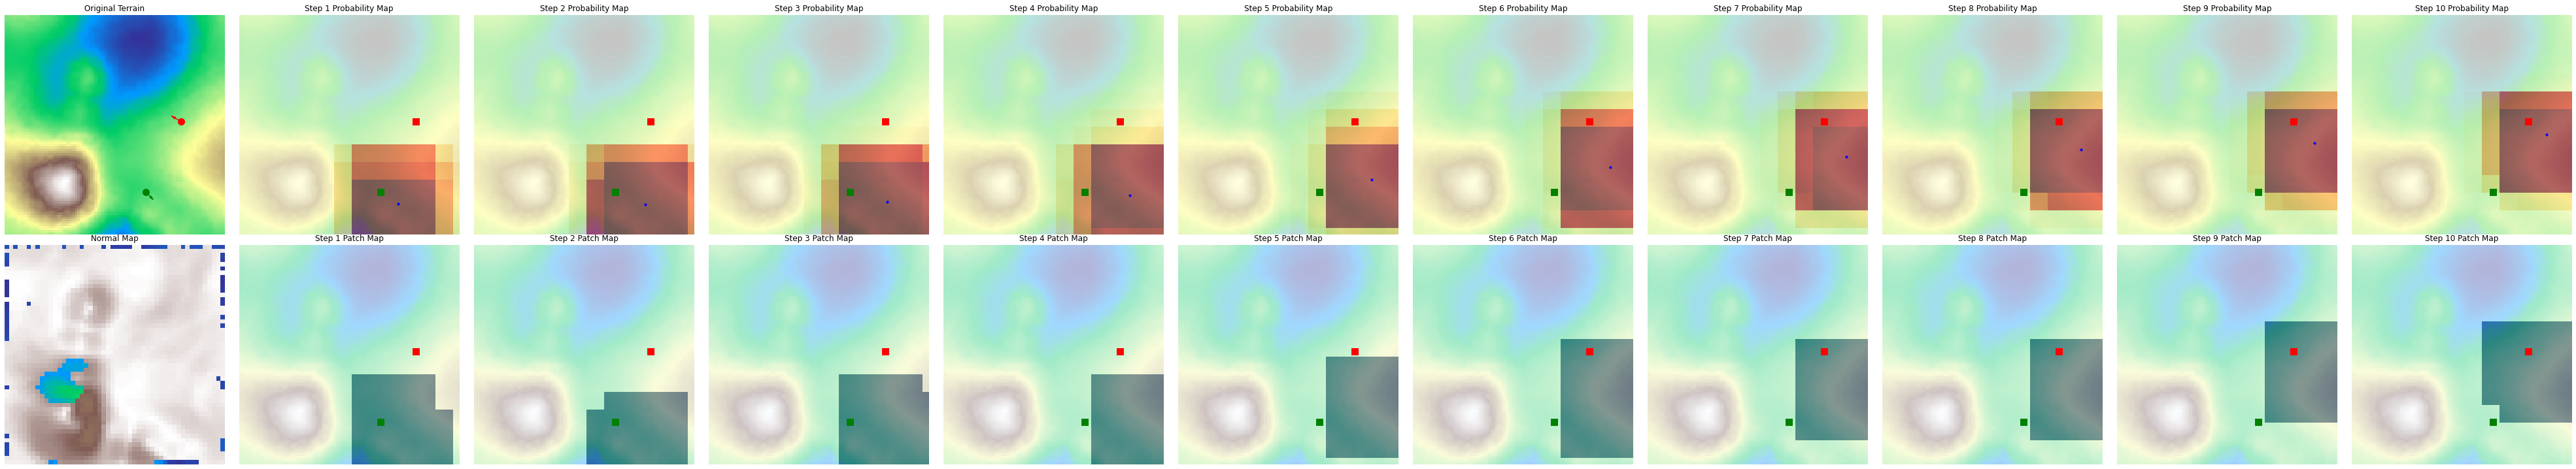

In [31]:
# 显示patch_map信息
print(f"patch_map shape: {patch_map.shape}")
print(f"predProb shape: {predProb.shape}")

# 创建子图来显示所有输出维度
output_dim = patch_map.shape[0]
fig, axes = plt.subplots(2, output_dim + 1, figsize=(5 * (output_dim + 1), 5*(2)))

# 显示原始地形图
im = axes[0, 0].imshow(elevation_masked, extent=[-5, 5, -5, 5],
                    origin='lower', cmap='terrain', aspect='equal')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].scatter(start_pos[0], start_pos[1], color='g', zorder=3, s=100)
axes[0, 0].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3, s=100)
# 绘制朝向
arrow_scale = 0.3
axes[0, 0].arrow(start_pos[0], start_pos[1],
             np.cos(start_pos[2]) * arrow_scale,
             np.sin(start_pos[2]) * arrow_scale,
             head_width=0.1, head_length=0.2, fc='g', ec='g', zorder=3)
axes[0, 0].arrow(goal_pos[0], goal_pos[1],
             np.cos(goal_pos[2]) * arrow_scale,
             np.sin(goal_pos[2]) * arrow_scale,
             head_width=0.1, head_length=0.2, fc='r', ec='r', zorder=3)
axes[0, 0].set_title('Original Terrain')
axes[0, 0].axis('off')

# 显示normal_z信息(在第二行第一个位置)
axes[1, 0].imshow(normal_z, extent=[-5, 5, -5, 5],
                  origin='lower', cmap='terrain', aspect='equal')
axes[1, 0].set_title('Normal Map')
axes[1, 0].axis('off')

# 显示每个输出维度的predProb（正确的感受野映射）
for i in range(output_dim):
    axes[0, i+1].imshow(elevation_masked, extent=[-5, 5, -5, 5],
                     origin='lower', cmap='terrain', aspect='equal', alpha=0.7)
    
    # 获取锚点的实际坐标和概率值
    hash_table = getHashTable(normal_z.shape)
    prob_values = predProb[i].cpu().detach().numpy()
    
    # 创建一个与地形图同样大小的概率图
    H, W = normal_z.shape
    prob_map = np.zeros((H, W))
    count_map = np.zeros((H, W))  # 用于计算重叠区域的平均值
    
    # 为每个锚点填充其感受野区域
    for anchor_idx, (y_pix, x_pix) in enumerate(hash_table):
        prob_value = prob_values[anchor_idx]
        
        # 计算感受野的边界
        half_rf = receptive_field // 2
        y_start = max(0, y_pix - half_rf)
        y_end = min(H, y_pix + half_rf)
        x_start = max(0, x_pix - half_rf)
        x_end = min(W, x_pix + half_rf)
        
        # 在感受野区域内填充概率值
        # 注意：prob_map[行, 列] = prob_map[y, x]
        # 在感受野区域内填充概率值 - 使用最大值而非累加
        prob_map[y_start:y_end, x_start:x_end] = np.maximum(
            prob_map[y_start:y_end, x_start:x_end], 
            prob_value)
    
    # 显示概率图 - 这里需要转置以正确显示xy坐标
    im = axes[0, i+1].imshow(prob_map.T, extent=[-5, 5, -5, 5],
                         origin='lower', cmap='YlOrRd', alpha=0.6)
    
    axes[0, i+1].scatter(start_pos[0], start_pos[1], color='g', zorder=3, s=100, marker='s')
    axes[0, i+1].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3, s=100, marker='s')
    axes[0, i+1].scatter(predTraj[i][0], predTraj[i][1], color='b', zorder=3, s=10, marker='o')
    axes[0, i+1].set_title(f'Step {i+1} Probability Map')
    axes[0, i+1].axis('off')
    
# 显示每个patch_map层
for i in range(output_dim):
    axes[1, i+1].imshow(elevation_masked, extent=[-5, 5, -5, 5],
                     origin='lower', cmap='terrain', aspect='equal', alpha=0.7)
    
    # 直接使用patch_map，它已经是正确的掩码形式(10, 100, 100)
    im = axes[1, i+1].imshow(patch_map[i], extent=[-5, 5, -5, 5],
                         origin='lower', cmap='Blues', alpha=0.5)

    axes[1, i+1].scatter(start_pos[0], start_pos[1], color='g', zorder=3, s=100, marker='s')
    axes[1, i+1].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3, s=100, marker='s')
    axes[1, i+1].set_title(f'Step {i+1} Patch Map')
    axes[1, i+1].axis('off')

plt.tight_layout()

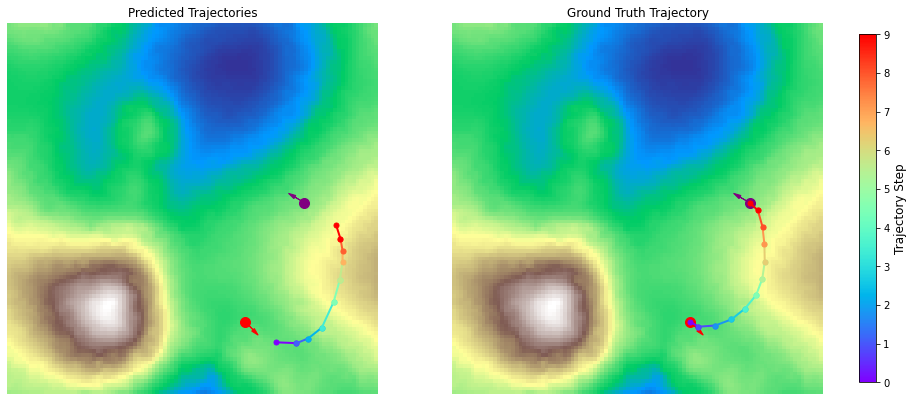

In [32]:
# 创建子图来显示所有输出维度
output_dim = patch_map.shape[0]
fig, axes = plt.subplots(1, 2, figsize=(8 * 2, 8))

# 显示原始地形图
im = axes[0].imshow(elevation_masked, extent=[-5, 5, -5, 5],
                    origin='lower', cmap='terrain', aspect='equal')
axes[0].grid(True, alpha=0.3)

# 绘制predTraj线段, 颜色由绿色到红色渐变
for i in range(output_dim-1):
    # color = plt.cm.RdYlGn_r(i / output_dim)  # 使用RdYlGn_r颜色映射
    color = plt.cm.rainbow(i / (output_dim - 2))  # 使用rainbow颜色映射
    axes[0].plot([predTraj[i][0], predTraj[i+1][0]], 
              [predTraj[i][1], predTraj[i+1][1]], 
              color=color, zorder=3, linewidth=2, marker='o', markersize=5)

axes[0].scatter(start_pos[0], start_pos[1], color='r', zorder=3, s=100)
axes[0].scatter(goal_pos[0], goal_pos[1], color='purple', zorder=3, s=100)
# 绘制朝向
arrow_scale = 0.3
axes[0].arrow(start_pos[0], start_pos[1],
             np.cos(start_pos[2]) * arrow_scale,
             np.sin(start_pos[2]) * arrow_scale,
             head_width=0.1, head_length=0.2, fc='r', ec='r', zorder=3)
axes[0].arrow(goal_pos[0], goal_pos[1],
             np.cos(goal_pos[2]) * arrow_scale,
             np.sin(goal_pos[2]) * arrow_scale,
             head_width=0.1, head_length=0.2, fc='purple', ec='purple', zorder=3)

axes[0].set_title('Predicted Trajectories')
axes[0].axis('off')

# 绘制第二个子图，显示ground truth的Traj
axes[1].imshow(elevation_masked, extent=[-5, 5, -5, 5],
                origin='lower', cmap='terrain', aspect='equal')
axes[1].grid(True, alpha=0.3)

# 绘制ground truth Traj
for i in range(trajectory.shape[0] - 1):
    color = plt.cm.rainbow(i / (trajectory.shape[0] - 2))  # 使用rainbow颜色映射
    axes[1].plot(trajectory[i:i+2, 0], trajectory[i:i+2, 1], color=color, zorder=3, linewidth=2, marker='o', markersize=5)
    
axes[1].scatter(start_pos[0], start_pos[1], color='r', zorder=3, s=100)
axes[1].scatter(goal_pos[0], goal_pos[1], color='purple', zorder=3, s=100)
# 绘制朝向
arrow_scale = 0.3
axes[1].arrow(start_pos[0], start_pos[1],
             np.cos(start_pos[2]) * arrow_scale,
             np.sin(start_pos[2]) * arrow_scale,
             head_width=0.1, head_length=0.2, fc='r', ec='r', zorder=3)
axes[1].arrow(goal_pos[0], goal_pos[1],
             np.cos(goal_pos[2]) * arrow_scale,
             np.sin(goal_pos[2]) * arrow_scale,
             head_width=0.1, head_length=0.2, fc='purple', ec='purple', zorder=3)
axes[1].set_title('Ground Truth Trajectory')
axes[1].axis('off')

# 为轨迹的颜色添加颜色条，不能影响原有的地形图，最小值为0，最大值为output_dim-1
norm = plt.Normalize(0, output_dim - 1)
cmap = plt.cm.rainbow
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes, shrink=0.8, fraction=0.046, pad=0.04)
cbar.set_label('Trajectory Step', fontsize=12)

### Plan RRT* or IRRT* Path

Choose either RRT* or IRRT* to plan the path on the given patches.

In [61]:
cost = np.linalg.norm(np.diff(path, axis=0), axis=1).sum()

method = 'rrtstar' # or 'informedrrtstar'
# method = 'informedrrtstar'
MPTpath, t, v, success = get_path(path[0,:], path[-1, :], MazeMap, patch_map, method, cost)
# MPTpath, t, v, success = get_path(start_pos, goal_pos, MazeMap, patch_map, method, cost)

MPTpixelPos = np.array([geom2pix(pos) for pos in MPTpath])

Found Solution


In [62]:
pathPix = [geom2pix(pos) for pos in path]

uniqueId = []
for pos in pathPix:
    if pos not in uniqueId:
        uniqueId.append(pos)
pathPixelPos = np.array([geom2pix(pos) for pos in data['path']])# Generate Patch Maps
truePatchMap = np.zeros_like(MazeMap)
map_size = MazeMap.shape
receptive_field = 32
for pos in uniqueId:
    goal_start_x = max(0, pos[0]- receptive_field//2)
    goal_start_y = max(0, pos[1]- receptive_field//2)
    goal_end_x = min(map_size[0], pos[0]+ receptive_field//2)
    goal_end_y = min(map_size[1], pos[1]+ receptive_field//2)
    truePatchMap[goal_start_y:goal_end_y, goal_start_x:goal_end_x] = 1.0

<IPython.core.display.Javascript object>


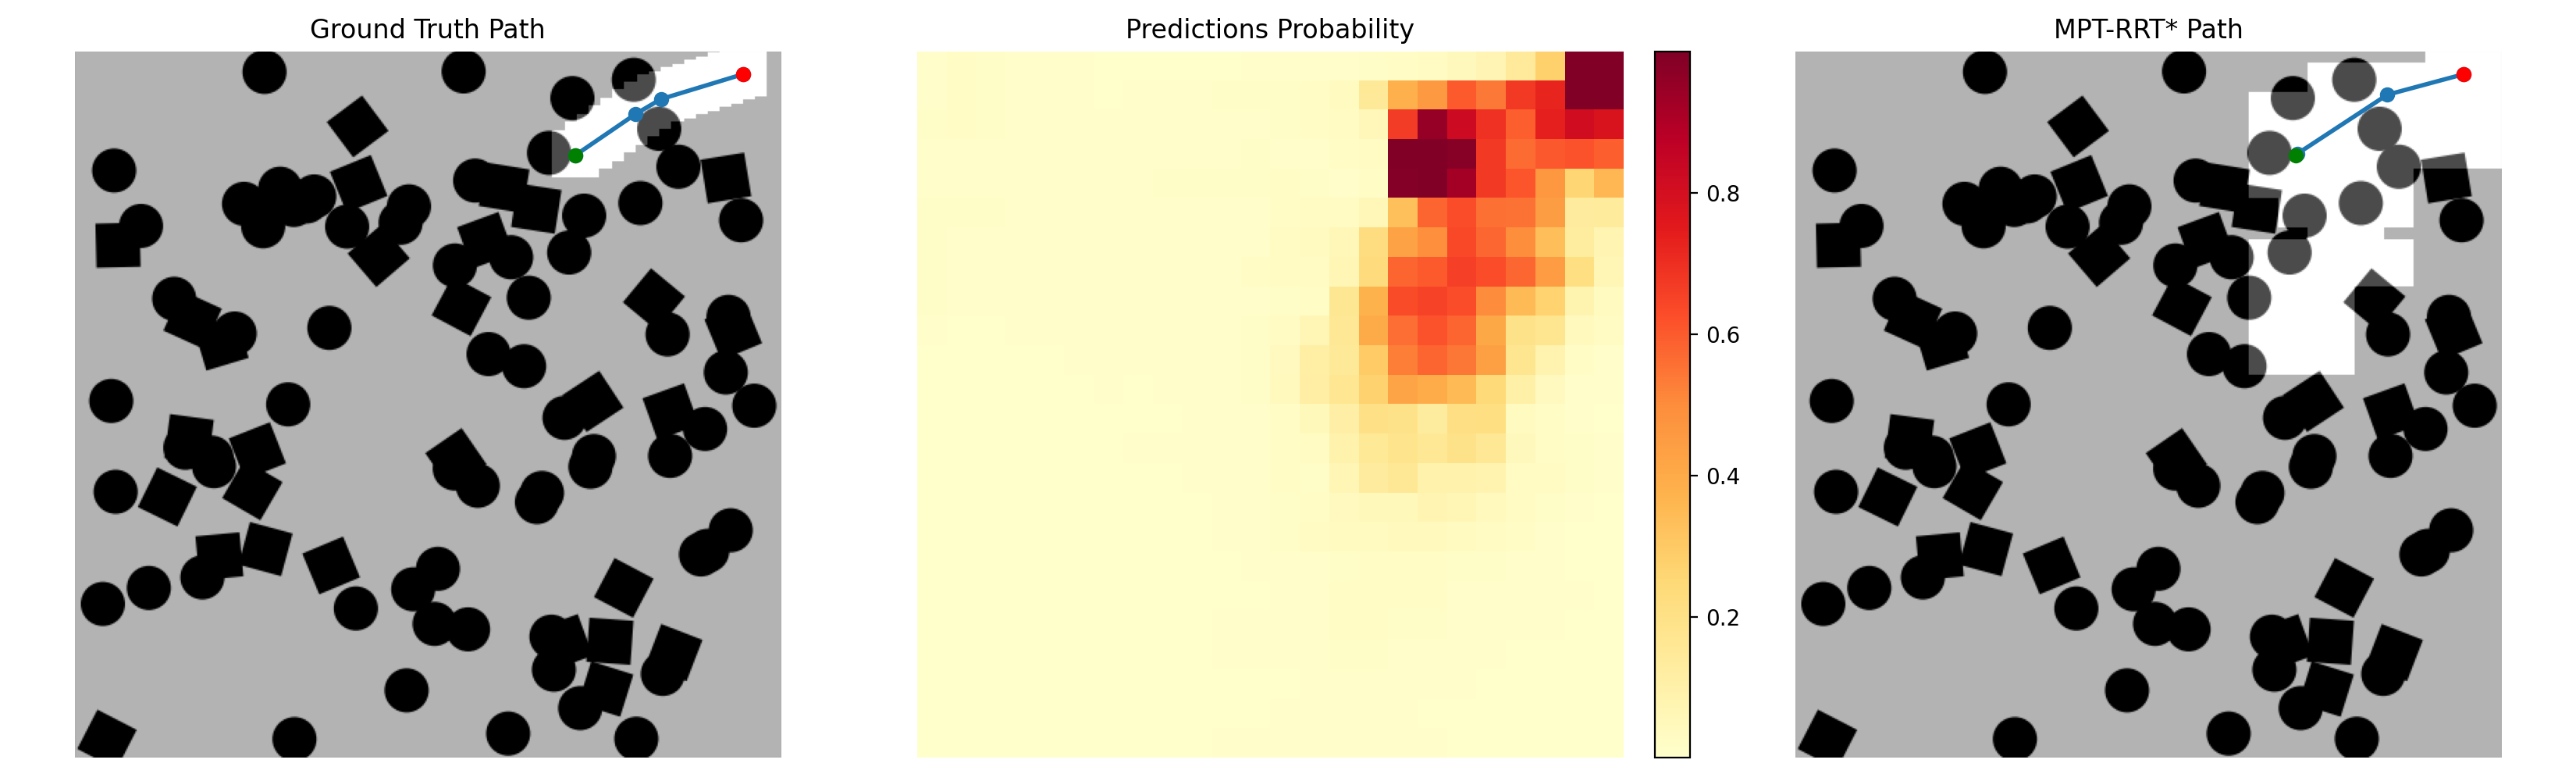

Saved visualization to predictions/forest/env000300_path_4_visualization.png


In [63]:
fig, ax = plt.subplots(1, 3, figsize=(16.5,5), dpi=100)

ax[0].set_title('Ground Truth Path')
ax[0].imshow(MazeMap, cmap='gray')
ax[0].imshow(truePatchMap, cmap='gray', alpha=0.3)
ax[0].plot(pathPixelPos[:,0], pathPixelPos[:,1], marker='o', linewidth=2)
ax[0].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[0].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[0].axis('off')

predMap = predProb[:, 1].cpu().detach().numpy()
im = ax[1].imshow(predMap.reshape((24, 24)), cmap="YlOrRd")
ax[1].set_title('Predictions Probability')
ax[1].axis('off')
cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

ax[2].set_title('MPT-RRT* Path')
ax[2].imshow(MazeMap, cmap='gray')
ax[2].imshow(patch_map, cmap='gray', alpha=0.3)
ax[2].plot(MPTpixelPos[:,0], MPTpixelPos[:,1], marker='o', linewidth=2)
ax[2].scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax[2].scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax[2].axis('off')
plt.tight_layout(w_pad=0.1)

output_folder = 'predictions'
target_dir = osp.join(output_folder, envType)

if not osp.exists(target_dir):
    os.makedirs(target_dir, exist_ok=True)

plt.savefig(osp.join(target_dir, f'env{env_num:06d}_path_{pathNum}_visualization.png'), dpi=300)
print(f'Saved visualization to {osp.join(target_dir, f"env{env_num:06d}_path_{pathNum}_visualization.png")}')

## Car Robot

### Load Trained Model

In [ ]:
# Define the network
device='cuda' if torch.cuda.is_available() else 'cpu'

modelFolder = '/data/car_robot'
car_robot = True
epoch = 69

modelFile = osp.join(modelFolder, f'model_params.json')
model_param = json.load(open(modelFile))

transformer = Models.Transformer(**model_param)
_ = transformer.to(device)

In [ ]:
checkpoint = torch.load(osp.join(modelFolder, f'model_epoch_{epoch}.pkl'))
transformer.load_state_dict(checkpoint['state_dict'])

_ = transformer.eval()

In [ ]:
# Plot the patches
env_num = 1
envFolder = f'/root/data/forest_car/val/env{env_num:06d}'
MazeMap = io.imread(osp.join(envFolder, f'map_{env_num}.png'), as_gray=True)

fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(MazeMap, cmap='gray')
ax.axis('off')

In [ ]:
# Plot the path
pathNum = 0
data = pickle.load(open(osp.join(envFolder, f'path_{pathNum}.p'), 'rb'))
path = data['path_interpolated']

goal_pos = geom2pix(path[0, :])
start_pos = geom2pix(path[-1, :])

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(MazeMap, cmap='gray')
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Generate Patch Map

In [ ]:
patch_map, predProb = get_patch(transformer, start_pos[::-1], goal_pos[::-1], MazeMap)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(MazeMap, cmap='gray')
ax.imshow(patch_map, cmap='gray', alpha=0.5)
ax.scatter(goal_pos[0], goal_pos[1], color='r', zorder=3)
ax.scatter(start_pos[0], start_pos[1], color='g', zorder=3)
ax.axis('off')

### Plan SST Path

In [ ]:
MPTpath, t, _, success = get_path_sst(path[0,:], path[-1, :], MazeMap, patch_map)

### Visualize Planned Trajectory

In [ ]:
from matplotlib.patches import Circle
def geom2pix(pos, res=0.05, size=(480, 480)):
    """ Copied from utils
    """
    return (np.int(np.floor(pos[0]/res)), np.int(size[0]-1-np.floor(pos[1]/res)))

def plot_traj(path, ax=plt,
              robot_color='C0', 
              start_color='g',
              goal_color='r',
              orientation_color='orange',
              footprint=False, res = 0.05, robot_radius=0.2):
    """A function plotting trajectories
    """
    inds = np.array([geom2pix(s) for s in path])
    robot_ind_size = robot_radius/res
    if footprint:
        for i in range(len(inds)):
            ind = inds[i]
            if i == 0:
                ax.add_patch(Circle(ind, robot_ind_size, color=start_color, zorder=3, alpha=1))
            elif i >= len(inds) - 1:
                ax.add_patch(Circle(ind, robot_ind_size, color=goal_color, zorder=3, alpha=1))
            else:
                ax.add_patch(Circle(ind, robot_ind_size, zorder=3))
            theta = -path[i][2]
            head_ind = [ind[0] + np.cos(theta) * robot_ind_size*2, ind[1] + np.sin(theta) * robot_ind_size*2]
            ax.plot([ind[0], head_ind[0]], [ind[1], head_ind[1]], c=orientation_color, zorder=4)
    ax.plot(inds[:, 0], inds[:, 1], c=robot_color, marker='o', linewidth=2)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))

ax.imshow(MazeMap, cmap='gray')
ax.imshow(patch_map, cmap='gray', alpha=0.5)
plot_traj(MPTpath, ax=ax, footprint=True)
ax.axis('off')